# PROJECT AML : UrbanSound8k

## Some information about the dataset
This dataset is composed of 6.6GB of data, including 8732 sound files of around 4 seconds(but less or equal) and 1 CSV file giving info about files where to find them in the dataset,their original file, their location in the original files, and of course their classes in ID but also with the name associated to it, also if the sound to detect is in foreground or background.

There are ten classes of sound and the aim of this project is to develop a classifier for this sound.

The ten classes are : airconditioner, carhorn, childrenplaying, dogbark, drilling, engineidling, gunshot, jackhammer, siren, street_music.

## How I will do it ?
So the idea is to develop a classifier I decided to use features generating a 2D representation of the sound and applying CNN on the generated representation to classify the classes.

## Some informations before running
You have to clone this folder : https://drive.google.com/drive/folders/1MH2S699CGllBy_HJhG2MUJ07uiyectY8?usp=sharing, to your drive and adapt paths according to your folder hierarchy.


**VERSION BIGNN :**
This is the version of the project using Transfer Learning on wide\_resnet\_50\_2, using images from spectrogram resized.

If you want to access the other version link here : 
https://colab.research.google.com/drive/1YydWStXOiJ4AO90AaDRcQ56RhqiargTs

## Imports and define some paths





In [ ]:
!pip install torchaudio==0.8.1
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

## Related to image processing
import cv2

## Related to sound
import torchaudio
import torchaudio.transforms as T
import IPython.display as ipd

## Related to deeplearning
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

## Related to data connect
from google.colab import drive

     |████████████████████████████████| 1.9MB 7.5MB/s 


In [ ]:
PATH_TO_FOLDER ="/MyDrive/SoundClassif/"
CSV_FILENAME = "UrbanSound8K.csv"
MOUNTING_LOCATION = "/content/drive"

# DF VARS
FILENAME = "slice_file_name"
FID = "fsID"
START = "start"
END = "end"
SL = 	"salience"	
FOLD = "fold"
CLASSID = "classID"
CLASS = "class"

## Define some processing and visualization functions


In [ ]:
def plot_spectrogram(waveform, title=None, ylabel='freq_bin', aspect='auto', axs = None):
  if axs is None :
    fig, axs = plt.subplots(1, 1)
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  amp = torchaudio.transforms.AmplitudeToDB('magnitude',top_db=80)
  res = amp(np.abs(torch.stft(waveform,2048)))[0]
  y = torch.sum(res.permute(2,0,1),axis =0)
  im = axs.imshow(y)
  plt.title(title or 'Spectrogram (db)')

def plot_waveform(waveform, sample_rate, title="Waveform", axes = None):
  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate
  waveform = waveform[0]
  if axes is None:
    figure, axes = plt.subplots(1, 1)
  plt.plot(time_axis, waveform, linewidth=1)
  plt.title(title)

def load_sound_by_index(file_index, df):
  sound_picked_fn = df[FILENAME][file_index]
  waveform, sr = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(df[FOLD][file_index])+os.path.sep+sound_picked_fn) # load audio
  audio_mono = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono
  return audio_mono

## Import data

In [ ]:
drive.mount(MOUNTING_LOCATION)

Mounted at /content/drive


In [ ]:
df = pd.read_csv(MOUNTING_LOCATION+PATH_TO_FOLDER+CSV_FILENAME)
#df = df.loc[df["fold"]==1].reset_index(drop=True)  ## Select only mounting folder 1
r,c = df.shape
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


##Exploratory data analysis

In [ ]:
print(f"In this dataset there is {df.shape[0]} sounds")

In this dataset there is 8732 sounds


Text(0.5, 1.0, 'Classes histogram')

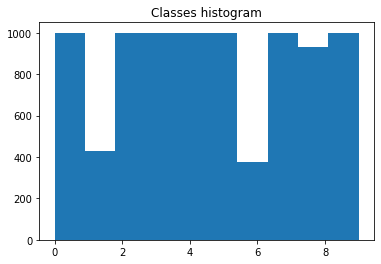

In [ ]:
plt.hist(df[CLASSID].values, bins=10,range=(0,9))
plt.title('Classes histogram')

Text(0.5, 1.0, 'Salience (1: Foreground, 2: Background)')

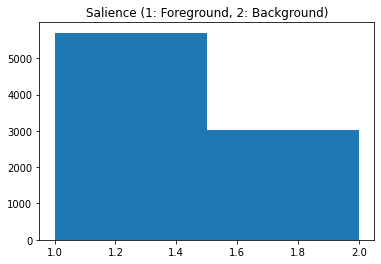

In [ ]:
plt.hist(df[SL].values, bins=2,range=(1,2))
plt.title('Salience (1: Foreground, 2: Background)')

In [ ]:
print(f"There is {len(np.unique(df[FID].values))} differents sources of sound in this dataset.")

There is 1297 differents sources of sound in this dataset.


Text(0.5, 1.0, 'Sources histogram')

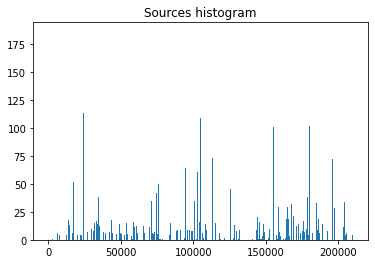

In [ ]:
plt.hist(df[FID].values, bins=len(np.unique(df[FID].values)))
plt.title('Sources histogram')

### Sample pick

In [ ]:
dfC1 = df[df[CLASSID]==1].reset_index(drop=True)
index = 20
sound_picked_fn = dfC1[FILENAME][index]
class_name1 = dfC1[CLASS][index]
waveform, sr1 = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(dfC1[FOLD][index])+os.path.sep+sound_picked_fn) # load audio
audio_mono1 = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono

dfC2 = df[df[CLASSID]==2].reset_index(drop=True)
sound_picked_fn = dfC2[FILENAME][0]
class_name2 = dfC2[CLASS][0]
waveform, sr2 = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(dfC2[FOLD][0])+os.path.sep+sound_picked_fn) # load audio
audio_mono2 = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono

dfC3 = df[df[CLASSID]==3].reset_index(drop=True)
sound_picked_fn = dfC3[FILENAME][10]
class_name3 = dfC3[CLASS][10]
waveform, sr3 = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(dfC3[FOLD][10])+os.path.sep+sound_picked_fn) # load audio
audio_mono3 = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono

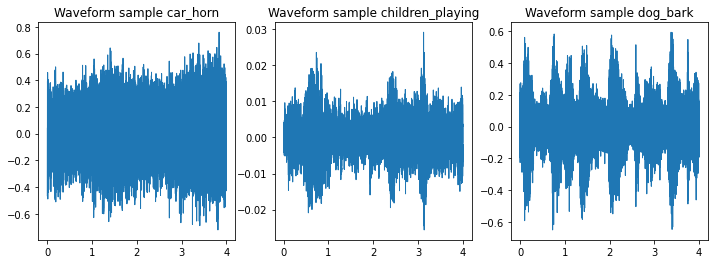

In [ ]:
sfig, saxs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

plt.sca(saxs[0])
plot_waveform(audio_mono1.numpy(),sr1, title="Waveform sample "+str(class_name1),axes=saxs[0])

plt.sca(saxs[1])
plot_waveform(audio_mono2.numpy(),sr2, title="Waveform sample "+str(class_name2),axes=saxs[1])

plt.sca(saxs[2])
plot_waveform(audio_mono3.numpy(),sr3,title="Waveform sample "+str(class_name3),axes=saxs[2])

/usr/local/lib/python3.7/dist-packages/torch/functional.py:581: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:639.)
  normalized, onesided, return_complex)


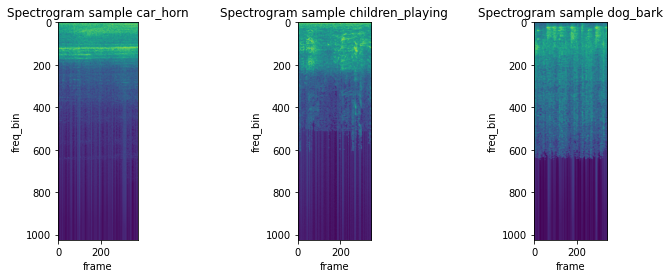

In [ ]:
mfig, maxs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.sca(maxs[0])
plot_spectrogram(audio_mono1, title="Spectrogram sample "+class_name1,axs=maxs[0])

plt.sca(maxs[1])
plot_spectrogram(audio_mono2, title="Spectrogram sample "+class_name2,axs=maxs[1])

plt.sca(maxs[2])
plot_spectrogram(audio_mono3, title="Spectrogram sample "+class_name3,axs=maxs[2])

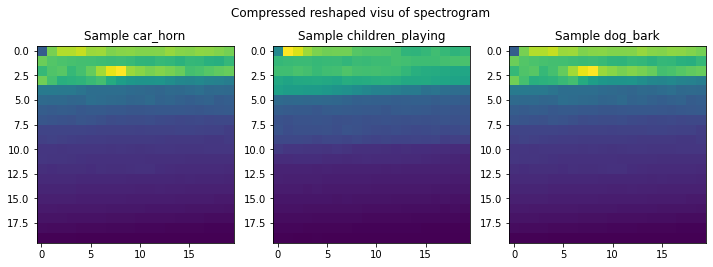

In [ ]:
amp = torchaudio.transforms.AmplitudeToDB('magnitude',top_db=80)
i1 = (torch.mean(torch.sum(amp(torch.abs(torch.stft(audio_mono1,799)[0])), axis=2).T, axis=0).reshape(20,20))
i2 = (torch.mean(torch.sum(amp(torch.abs(torch.stft(audio_mono2,799)[0])), axis=2).T, axis=0).reshape(20,20))
i3 = (torch.mean(torch.sum(amp(torch.abs(torch.stft(audio_mono3,799)[0])), axis=2).T, axis=0).reshape(20,20))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.sca(axs[0])
plt.imshow(i1)
plt.title("Sample "+class_name1)
plt.sca(axs[1])
plt.imshow(i2)
plt.title("Sample "+class_name2)
plt.sca(axs[2])
plt.imshow(i1)
plt.title("Sample "+class_name3)
plt.suptitle('Compressed reshaped visu of spectrogram')
plt.show()

## Preprocessing


In [ ]:
arrOfImages = []
amp = torchaudio.transforms.AmplitudeToDB('magnitude',top_db=80)

def specAndResize(i):
    return  cv2.resize(torch.sum(amp(torch.abs(torch.stft(load_sound_by_index(i, df),799)[0])), axis=2).numpy(),(100,100))

for i in range(0, df.shape[0]):
  if (i%500 == 0):
    print("Preprocessed percentage : "+str(int((i/df.shape[0])*100)))
  arrOfImages.append(specAndResize(i))
  
arrOfImages = np.array(arrOfImages)

Preprocessed percentage : 0
Preprocessed percentage : 5
Preprocessed percentage : 11
Preprocessed percentage : 17
Preprocessed percentage : 22
Preprocessed percentage : 28
Preprocessed percentage : 34
Preprocessed percentage : 40
Preprocessed percentage : 45
Preprocessed percentage : 51
Preprocessed percentage : 57
Preprocessed percentage : 62
Preprocessed percentage : 68
Preprocessed percentage : 74
Preprocessed percentage : 80
Preprocessed percentage : 85
Preprocessed percentage : 91
Preprocessed percentage : 97


In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
class SoundDataset(Dataset):
  
    def __init__(self, dataframe, arrayOfImages , transform=None):
        """
        Args:
            dataframe (Panda df): dataframe for sounds
            transform (callable, optional): Optional transform to be applied
                on a sample.
            images (numpy array 2D) : Array of images (compressed spectrograms)
        """
        self.sound_frame = dataframe
        self.transform = transform
        self.images = arrayOfImages

    def __len__(self):
        return len(self.sound_frame)

    def filename(self, idx):
      return os.path.join(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+str(self.sound_frame[FOLD][idx])+os.path.sep,self.sound_frame[FILENAME][idx]) #self.sound_frame.iloc[idx, 5] self.sound_frame.iloc[idx, 0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        spec = self.images.squeeze()[idx]
        image = np.repeat(spec[..., np.newaxis], 3, -1)
        #image=spec
        target = self.sound_frame[CLASSID][idx] #self.sound_frame.iloc[idx, 6]

        #print(image.shape)
        if self.transform:
            image = self.transform(image)

        return image, target

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((100,100)), transforms.Normalize(np.mean(arrOfImages),np.std(arrOfImages))])

ds = SoundDataset(df,arrOfImages, transform=transform)
train_set, val_test_set = torch.utils.data.random_split(ds, [round(r*0.6), r-round(r*0.6)])
test_set, val_set = torch.utils.data.random_split(val_test_set, [int((r-round(r*0.6))*0.5),int((r-round(r*0.6))*0.5)+1])#+1
train_loader = DataLoader(train_set, batch_size=16,shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=16,shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=16,shuffle=True, num_workers=2)

cuda


In [ ]:
model = models.wide_resnet50_2(pretrained=True)

#for param in model.parameters():
#    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([('fc1', nn.Dropout(0.4)),('fc2', nn.Linear(2048, 10)), ('sf', nn.LogSoftmax())]))
    
model.fc = classifier

criterion = nn.NLLLoss()
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = 0.0001, amsgrad=True)

epochs = 20
steps = 0
running_loss = 0
loss_tab = []
val_loss_tab = []
val_acc_tab = []
acc_tab = []
accuracy = 0
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
 
        res = model(inputs)
        loss = criterion(res, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()     
    
        top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)
        valid_pred = top_class == labels.view(*top_class.shape)
        count = torch.mean((valid_pred).type(torch.FloatTensor))
        accuracy += count
    val_loss = 0
    val_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            res = model(inputs)
            valR_loss = criterion(res, labels)

            val_loss += valR_loss.item()
            top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)
            valid_pred = top_class == labels.view(*top_class.shape)
            count = torch.mean((valid_pred).type(torch.FloatTensor))
            val_accuracy += count
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.3f}.. "
          f"Val loss: {val_loss/len(val_loader):.3f}.. "
          f"Val accuracy: {val_accuracy/len(val_loader):.3f}")
    val_loss_tab.append(val_loss/len(val_loader))
    loss_tab.append(val_loss/len(train_loader))
    val_acc_tab.append(val_accuracy/len(val_loader))
    acc_tab.append(accuracy/len(train_loader))
    accuracy = 0
    running_loss = 0
    model.train()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1/20.. Train loss: 1.169.. Val loss: 0.639.. Val accuracy: 0.785
Epoch 2/20.. Train loss: 0.587.. Val loss: 0.495.. Val accuracy: 0.859
Epoch 3/20.. Train loss: 0.345.. Val loss: 0.438.. Val accuracy: 0.867
Epoch 4/20.. Train loss: 0.244.. Val loss: 0.396.. Val accuracy: 0.886
Epoch 5/20.. Train loss: 0.187.. Val loss: 0.364.. Val accuracy: 0.891
Epoch 6/20.. Train loss: 0.143.. Val loss: 0.386.. Val accuracy: 0.893
Epoch 7/20.. Train loss: 0.099.. Val loss: 0.370.. Val accuracy: 0.898
Epoch 8/20.. Train loss: 0.066.. Val loss: 0.365.. Val accuracy: 0.900
Epoch 9/20.. Train loss: 0.074.. Val loss: 0.329.. Val accuracy: 0.907
Epoch 10/20.. Train loss: 0.037.. Val loss: 0.306.. Val accuracy: 0.914
Epoch 11/20.. Train loss: 0.036.. Val loss: 0.363.. Val accuracy: 0.914
Epoch 12/20.. Train loss: 0.033.. Val loss: 0.347.. Val accuracy: 0.917
Epoch 13/20.. Train loss: 0.043.. Val loss: 0.326.. Val accuracy: 0.916
Epoch 14/20.. Train loss: 0.037.. Val loss: 0.384.. Val accuracy: 0.909
E

In [ ]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        # TODO: validation and test_loss update
        inputs, labels = inputs.to(device), labels.to(device)
        res = model(inputs)
        testR_loss = criterion(res, labels)

        test_loss += testR_loss.item()
        top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)

        valid_pred = top_class == labels.view(*top_class.shape)
        # TODO: accuracy update
        count = torch.mean((valid_pred).type(torch.FloatTensor))
        accuracy += count

print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test accuracy: 0.938


In [ ]:
# Save weights
torch.save(model.state_dict(), "model_big.h5")

## Metrics


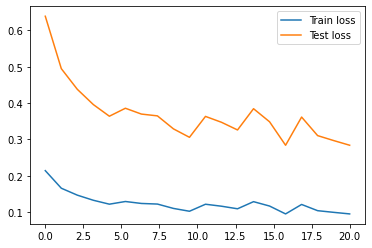

In [ ]:
# loss curves
x = np.linspace(0,len(loss_tab), len(val_loss_tab))
plt.plot(x, loss_tab, label= "Train loss")
plt.plot(x, val_loss_tab, label = "Test loss")
plt.legend()

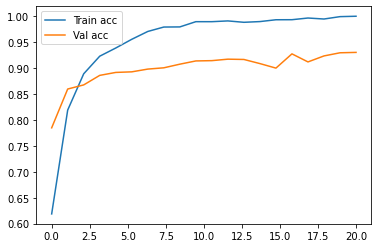

In [ ]:
#Accuracy curves
x = np.linspace(0,len(acc_tab), len(val_acc_tab))
plt.plot(x, acc_tab, label= "Train acc")
plt.plot(x, val_acc_tab, label = "Val acc")
plt.legend()

In [ ]:
model.eval()
labels_tab =[]
pred_tab =[]
model_test = model.to("cpu")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels
        res = model_test(inputs)
        top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)
        labels_tab.append(labels.clone().detach().to("cpu"))
        pred_tab.append(top_class.clone().detach().to("cpu"))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0.5, 0, 'Predicted label')

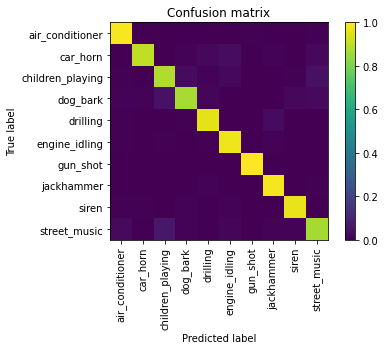

In [ ]:
classes = []
for values in range(0,10):
  classes.append(df[df[CLASSID] == values][CLASS].reset_index()[CLASS][0])

from sklearn.metrics import confusion_matrix
labels = np.concatenate([el.numpy() for el in labels_tab]).ravel()

pred = np.concatenate([el.numpy() for el in pred_tab]).ravel()

cm = confusion_matrix(labels, pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

fmt = '.2f' 
thresh = cm.max() / 2.

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Predict

In [ ]:
# Can import model from saved weights
model = models.wide_resnet50_2()
classifier = nn.Sequential(OrderedDict([('fc1', nn.Dropout(0.4)),('fc2', nn.Linear(2048, 10)), ('sf', nn.LogSoftmax())]))
model.fc = classifier

model.load_state_dict(torch.load("model_big.h5"))
model = model.to("cpu")
model.eval()
i = int(np.random.random()*df.shape[0])
w = load_sound_by_index(i, df)
spec = cv2.resize(torch.sum(amp(torch.abs(torch.stft(w,799)[0])), axis=2).numpy(),(100,100))
im = np.repeat(spec[..., np.newaxis], 3, -1)
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((100,100)), transforms.Normalize(np.mean(arrOfImages),np.std(arrOfImages))])
im = torch.unsqueeze(transform(im),0)
res = model(im)
filepath = MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+str(df[FOLD][i])+os.path.sep+df[FILENAME][i]
prob, ind= torch.topk(torch.exp(res), 1,dim=1)
print(f"proba : {prob.item():.2f}")
print(f"Classe la plus probable {classes[ind]}")
ipd.Audio(filepath)

proba : 1.00
Classe la plus probable siren


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## Observations : 



We can see that loss go down to 0.232 on val set and we get over 0.93 on accuracy of validation set. The results are really good.
We can see with confusion matrix that results seems pretty balanced, the class with the "lowest" good prediction rate seems to be car horn with biggest confusion with street music.

Thanks to the use of Residual neural network, our network is able to adapt really quickly to our dataset from the imagenet weights and to be really efficient without so much epochs.